In [1]:
import importlib
%matplotlib inline

In [2]:
import data.VCTK
importlib.reload(data.VCTK)
dataset = data.VCTK.VCTKDataset(
    text_file_paths=["out/tom.txt", "out/tom_pred.txt"],
    audio_file_paths=["out/tom.wav", "out/tom_pred.wav"]
)

In [3]:
y = dataset[0]
y_pred = dataset[1]

/home/azureuser/dom/Project/data/VCTK.py:76: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168786/work/torch/csrc/utils/tensor_new.cpp:201.)
  return text, torch.tensor(clips), torch.tensor(spectros)


In [4]:
audio = data.VCTK.VCTKDataset.stitch_audio(y[1])
audio_pred = data.VCTK.VCTKDataset.stitch_audio(y_pred[1])

# Preview

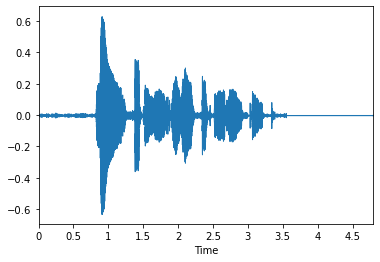

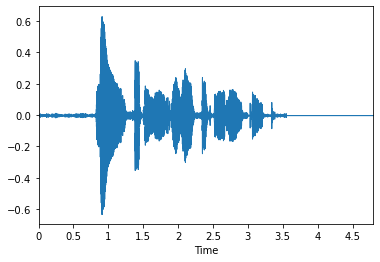

In [5]:
data.VCTK.VCTKDataset.show_audios([audio, audio_pred])

In [6]:
spectro = data.VCTK.VCTKDataset.stitch_spectros(y[2])
spectro_pred = data.VCTK.VCTKDataset.stitch_spectros(y_pred[2])
print(spectro.shape, spectro_pred.shape)

torch.Size([80, 387]) torch.Size([80, 387])


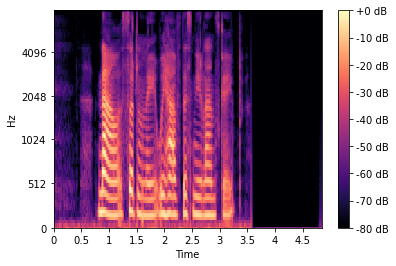

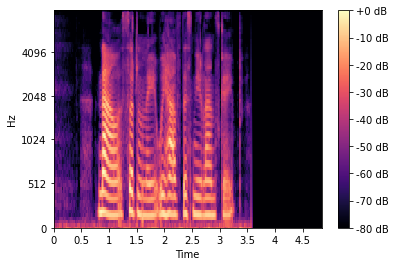

In [7]:
dataset.show_spectros([spectro, spectro_pred])

# Calculate MCD

This uses a lot of code from [here](https://github.com/SamuelBroughton/Mel-Cepstral-Distortion/blob/master/mel-cepstral-distortion.ipynb)

In [8]:
import math
def log_spec_dB_dist(x, y):
    log_spec_dB_const = 10.0 / math.log(10.0) * math.sqrt(2.0)
    diff = x - y
    
    return log_spec_dB_const * math.sqrt(np.inner(diff, diff))

In [55]:
!pip uninstall -y enum34 --quiet
!pip install pyworld --quiet

In [56]:
!pip install pysptk --quiet

In [9]:
import pyworld
import pysptk.sptk
def wav2mcep(wav,  alpha=0.65, fft_size=512, mcep_size=34):
    # Use WORLD vocoder to spectral envelope
    _, sp, _ = pyworld.wav2world(
        wav.numpy().astype(np.double),
        fs=16000,
        frame_period=5.0,
        fft_size=fft_size
    )

    # Extract MCEP features
    mgc = pysptk.sptk.mcep(
        sp,
        order=mcep_size,
        alpha=alpha,
        maxiter=0,
        etype=1,
        eps=1.0E-8,
        min_det=0.0,
        itype=3
    )
    
    return mgc

In [10]:
import librosa.sequence
import numpy as np
def average_mcd(mcep_list, mcep_list_pred, cost_function):
    min_cost_tot = 0.0
    frame_count = 0
    
    for mcep, mcep_pred in zip(mcep_list, mcep_list_pred):
        # dynamic time warping using librosa
        min_cost, _ = librosa.sequence.dtw(
            mcep[:, 1:].T,
            mcep_pred[:, 1:].T,
            metric=cost_function
        )
        
        min_cost_tot += np.mean(min_cost)
        frame_count += len(mcep)

    mean_mcd = min_cost_tot / frame_count
    
    return mean_mcd, frame_count

In [11]:
real_mcd_list = [wav2mcep(v) for v in [audio]]
pred_mcd_list = [wav2mcep(v) for v in [audio_pred]]

avg_mcd, frame_count = average_mcd(real_mcd_list, pred_mcd_list, log_spec_dB_dist)
print(f"MCD = {avg_mcd} over {frame_count} frames")

MCD = 3.4911612442159776 over 961 frames
